# Building an Energy Model

In this notebook, we will build a really simple model of the Austrian energy system from scratch. The process will involve defining our model's time horizon and spatial extent, and then populating the model with data associated with model parameters. Once we have a basline model, we will then move on to investigating policy scenarios.

We will be populating different kinds of parameters including

### Economic Parameters

- `interestrate`
- `demand`

### Technology Parameters

#### Engineering Parameters

- `input`
- `output`
- `technical_lifetime`
- `capacity_factor`


#### Technoeconomic Parameters

- `inv_cost`
- `fix_cost`
- `var_cost`

### Dynamic Behavior Parameters

- `bound_activity_up`
- `bound_activity_lo`
- `bound_new_capacity_up`
- `initial_activity_up`
- `growth_activity_up`

### Emissions

- `emission_factor`

A full list of parameters can be found on the (internal) [MESSAGEix documentation website](http://ienecat.iiasa.ac.at:8787/message_ix_doc). This website can be built in the future from the repository that you are using. 

## The Final Product

At the completion of this exercise, we will have developed an energy model is comprised of the below Reference Energy System (RES):

![title](austria.png)



## Setup

In [1]:
# load required packages 
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from ixmp import ixPlatform

In [2]:
# launch the IX modeling platform using the local default database                                                                                                                       
mp = ixPlatform(dbtype='HSQLDB') # use dbtype='HSQLDB' for a local database

In [3]:
model = "Israeli energy model"
scen = "baseline"
annot = "developing a stylized energy system model for illustration and testing" 

ds = mp.datastructure(model, scen, version='new', annotation=annot, scheme="MESSAGE")

## Time and Spatial Detail

In [4]:
horizon = list(range(2010, 2050, 10))
firstyear = horizon[0]

In [5]:
ds.add_set("year", horizon)
ds.add_set("cat_year", ["firstmodelyear", firstyear])

In [6]:
country = "Israel"
ds.add_set("node", country)
ds.add_set("lvl_spatial", "country")
ds.add_set("map_spatial_hierarchy", ["country", country, "World"])
ds.add_set("mode", "standard")

In [7]:
ds.add_set("commodity", ["electricity", "light", "other_electricity"])
ds.add_set("level", ["secondary", "final", "useful"])

## Economic Parameters

In [8]:
rate = [0.05] * len(horizon)
unit = ['%'] * len(horizon)
ds.add_par("interestrate", key=horizon, val=rate, unit=unit)

In [9]:
beta = 0.7
gdp = pd.Series([1., 1.52395, 2.17362, 2.97357], index=horizon)#, 1.89083, 2.14474], index=horizon)
demand = gdp ** beta

## Technologies

In [10]:
plants = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", # actually primary -> final
]
secondary_energy_techs = plants + ['import', 'export']

final_energy_techs = ['electricity_grid']

lights = [
    "bulb", 
    "cfl", 
]
useful_energy_techs = lights + ['appliances']

In [11]:
technologies = secondary_energy_techs + final_energy_techs + useful_energy_techs
ds.add_set("technology", technologies)

In [12]:
investment_technologies = plants + lights
ds.add_set("cat_tec", [['investment', tec] for tec in investment_technologies])

In [13]:
demand_per_year = 43855. / 8760 # from IEA statistics
elec_demand = pd.DataFrame({
        'node': country,
        'commodity': 'other_electricity',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': demand_per_year * demand,
        'unit': 'GWa',
    })
ds.add_par("demand", elec_demand)

demand_per_year = 4873. / 8760 # from IEA statistics
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': demand_per_year * demand,
        'unit': 'GWa',
    })
ds.add_par("demand", light_demand)

### Engineering Parameters

In [14]:
year_pairs = [(y_v, y_a) for y_v, y_a in itertools.product(horizon, horizon) if y_v <= y_a]
vintage_years, act_years = zip(*year_pairs)

In [15]:
base_input = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

grid = pd.DataFrame(dict(
        technology = 'electricity_grid',
        level = 'secondary',
        value = 1.0,
        unit = '%',
        **base_input
        ))
ds.add_par("input", grid)


bulb = pd.DataFrame(dict(
        technology = 'bulb',
        level = 'final',
        value = 1.0,
        unit = '%',
        **base_input
        ))
ds.add_par("input", bulb)

cfl = pd.DataFrame(dict(
        technology = 'cfl',
        level = 'final',
        value = 0.3, 
        unit = '%',
        **base_input
        ))
ds.add_par("input", cfl)

app = pd.DataFrame(dict(
        technology = 'appliances',
        level = 'final',
        value = 1.0,
        unit = '%',
        **base_input
        ))
ds.add_par("input", app)

In [16]:
def make_df(base, **kwargs):
    base.update(kwargs)
    return pd.DataFrame(base)

In [17]:
base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '%',
}

imports = make_df(base_output, technology='import', commodity='electricity', 
                  level='secondary', value=1.)
ds.add_par('output', imports)

exports = make_df(base_output, technology='export', commodity='electricity', 
                  level='secondary', value=1.)
ds.add_par('output', exports)

grid = make_df(base_output, technology='electricity_grid', commodity='electricity', 
               level='final', value=0.873)
ds.add_par('output', grid)

bulb = make_df(base_output, technology='bulb', commodity='light', 
               level='useful', value=1.)
ds.add_par('output', bulb)

cfl = make_df(base_output, technology='cfl', commodity='light', 
              level='useful', value=1.)
ds.add_par('output', cfl)

app = make_df(base_output, technology='appliances', commodity='other_electricity', 
              level='useful', value=1.)
ds.add_par('output', app)

coal = make_df(base_output, technology='coal_ppl', commodity='electricity', 
               level='secondary', value=1.)
ds.add_par('output', coal)

gas = make_df(base_output, technology='gas_ppl', commodity='electricity', 
              level='secondary', value=1.)
ds.add_par('output', gas)

oil = make_df(base_output, technology='oil_ppl', commodity='electricity', 
              level='secondary', value=1.)
ds.add_par('output', oil)

bio = make_df(base_output, technology='bio_ppl', commodity='electricity', 
              level='secondary', value=1.)
ds.add_par('output', bio)

hydro = make_df(base_output, technology='hydro_ppl', commodity='electricity', 
                level='secondary', value=1.)
ds.add_par('output', hydro)

wind = make_df(base_output, technology='wind_ppl', commodity='electricity', 
               level='secondary', value=1.)
ds.add_par('output', wind)

solar_pv = make_df(base_output, technology='solar_pv_ppl', commodity='electricity', 
                   level='final', value=1.)
ds.add_par('output', solar_pv)

In [18]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

lifetimes = {
    'coal_ppl': 40,
    'gas_ppl': 30,
    'oil_ppl': 30,
    'bio_ppl': 30,
    'hydro_ppl': 60,
    'wind_ppl': 20,
    'solar_pv_ppl': 20,
    'bulb': 1,
    'cfl': 10,
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    ds.add_par('technical_lifetime', df)

In [19]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '%',
}

capacity_factor = {
    'coal_ppl': 0.85,
    'gas_ppl': 0.75,
    'oil_ppl': 0.75,
    'bio_ppl': 0.75,
    'hydro_ppl': 0.5,
    'wind_ppl': 0.2,
    'solar_pv_ppl': 0.15,
    'bulb': 0.1, 
    'cfl':  0.1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    ds.add_par('capacity_factor', df)

### Technoeconomic Parameters

In [20]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'USD/GWa',
}

# in $ / kW
costs = {
    'coal_ppl': 1500,
    'gas_ppl':  870,
    'oil_ppl':  950,
    'hydro_ppl': 3000,
    'bio_ppl':  1600,
    'wind_ppl': 1100,
    'solar_pv_ppl': 4000,
    'bulb': 5,
    'cfl':  900, 
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val * 1e6)
    ds.add_par('inv_cost', df)

In [21]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/GWa',
}

# in $ / kW
costs = {
    'coal_ppl': 40,
    'gas_ppl':  25,
    'oil_ppl':  25,
    'hydro_ppl': 60,
    'bio_ppl':  30,
    'wind_ppl': 40,
    'solar_pv_ppl': 25,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val * 1e6)
    ds.add_par('fix_cost', df)

In [22]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/GWa',
}

# in $ / MWh
costs = {
    'coal_ppl': 24.4,
    'gas_ppl':  42.4,
    'oil_ppl':  77.8,
    'bio_ppl':  48.2,
    'electricity_grid': 47.8,
    'export': -20.,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val * 8760. * 1e3)
    ds.add_par('var_cost', df)

## Dynamic Behavior Parameters

In [23]:
base_growth = {
    'node_loc': country,
    'year_act': horizon[1:],
    'value': 0.05,
    'time': 'year',
    'unit': '%',
}

growth_technologies = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", 
    "cfl",
    "bulb",
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec)
    ds.add_par('growth_activity_up', df)

In [24]:
base_initial = {
    'node_loc': country,
    'year_act': horizon[1:],
    'time': 'year',
    'unit': '%',
}

for tec in lights:
    df = make_df(base_initial, technology=tec, value=0.01 * light_demand['value'].loc[horizon[1:]])
    ds.add_par('initial_activity_up', df)

In [25]:
base_activity = {
    'node_loc': country,
    'year_act': [2010],
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

# in GWh - from IEA Electricity Output
activity = {
    'coal_ppl': 34289,
    'gas_ppl':  21955,
    'oil_ppl':  2145,
    'hydro_ppl': 29,
    'bio_ppl':  38,
    'wind_ppl': 8,
    'solar_pv_ppl': 70,
    'import': 0,
    'cfl': 0,
    'export': 3967
}

for tec, val in activity.items():
    df = make_df(base_activity, technology=tec, value=val / 8760.)
    ds.add_par('bound_activity_up', df)
    ds.add_par('bound_activity_lo', df)

In [26]:
base_activity = {
    'node_loc': country,
    'year_act': horizon[1:],
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

# in GWh - base value from IEA Electricity Output
keep_activity = {
    'hydro_ppl': 29,
    'bio_ppl':  38,
    'import': 0,
    'export': 3967
}

for tec, val in keep_activity.items():
    df = make_df(base_activity, technology=tec, value=val / 8760.)
    ds.add_par('bound_activity_up', df)

In [27]:
base_capacity = {
    'node_loc': country,
    'year_vtg': [2010],
    'unit': 'GWa',
}

cf = pd.Series(capacity_factor)
act = pd.Series(activity)
capacity = (act / 8760 / cf).dropna().to_dict()

for tec, val in capacity.items():
    df = make_df(base_capacity, technology=tec, value=val)
    ds.add_par('bound_new_capacity_up', df)

## Emissions

In [28]:
ds.add_set("emission", "CO2")
ds.add_cat('emission', 'GHGs', 'CO2')

In [29]:
base_emissions = {
    'node_loc': country,
    'year_vtg': horizon,
    'mode': 'standard',
    'unit': 'kg/kWa', # actually is tCO2/GWa
}

# units: tCO2/MWh
emissions = {
    'coal_ppl': ('CO2', 0.854),
    'gas_ppl':  ('CO2', 0.339),
    'oil_ppl':  ('CO2', 0.57),
}

for tec, (species, val) in emissions.items():
    df = make_df(base_emissions, technology=tec, emission=species, value=val * 8760. * 1000)
    ds.add_par('emission_factor', df)

## Solve the Model

In [30]:
comment = 'initial commit for Israel model'
ds.commit(comment)
ds.set_as_default()

In [31]:
ds.solve("Isreal")

In [32]:
import os

In [33]:
os.chdir('../tutorial')

# Plotting Results

In [34]:
from tools import Plots
p = Plots(ds, country)

In [35]:
os.getcwd()

'c:\\Users\\User\\Documents\\IIASA\\MESSAGEix\\message_ix\\tutorial'

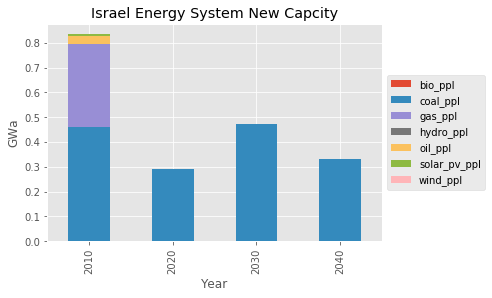

In [36]:
p.plot_new_capacity(baseyear=True, subset=plants)

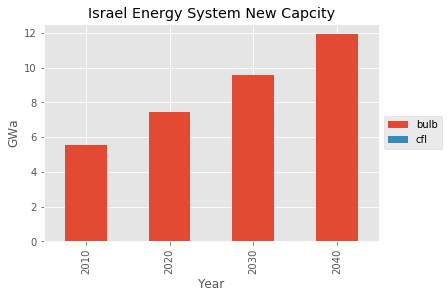

In [37]:
p.plot_new_capacity(baseyear=True, subset=lights)

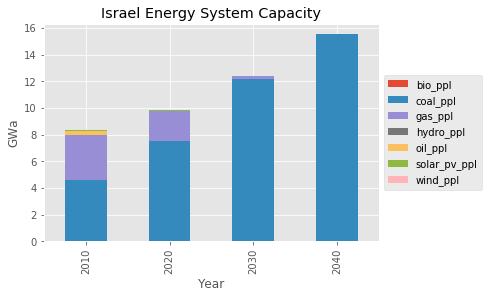

In [38]:
p.plot_capacity(baseyear=True, subset=plants)

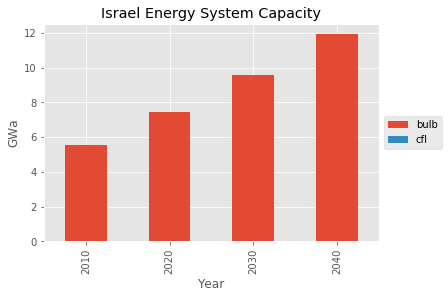

In [39]:
p.plot_capacity(baseyear=True, subset=lights)

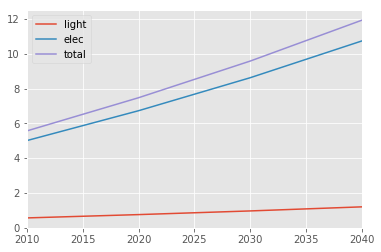

In [40]:
p.plot_demand(light_demand, elec_demand)

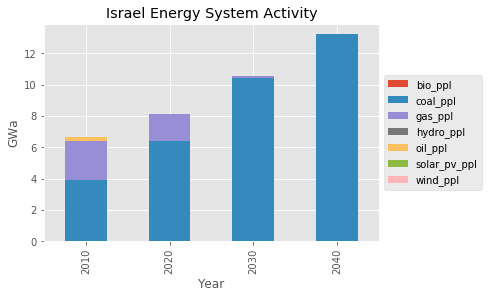

In [41]:
p.plot_activity(baseyear=True, subset=plants)

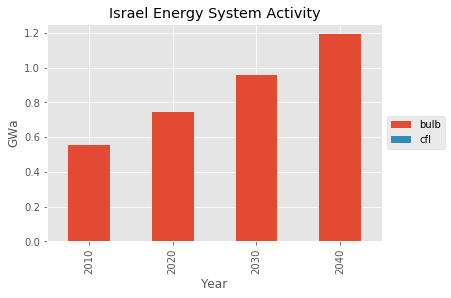

In [42]:
p.plot_activity(baseyear=True, subset=lights)

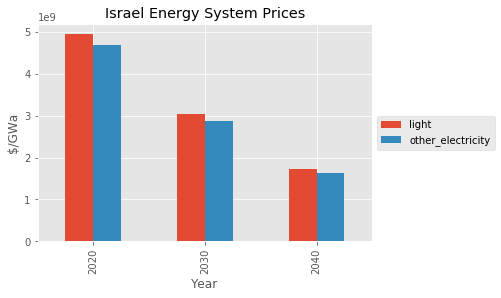

In [43]:
p.plot_prices(baseyear=False, subset=['light', 'other_electricity'])

In [44]:
mp.close_db() # only close if you're on a local database!